This is a Google Colab notebook, which from scratch computes pre-trained ViT and ResNet-50 feature vectors. It further contains the training of ResNet-50 on three different versions of synthetic tasks on synthetic data.

Here we only create the feature vectors (or rather provide the base code to create them). We will evaluate the features in the DL_Models_Evaluation_clean.jpynb. We provide the feature vectors we've generated on google drive (see how to access them in DL_Models_Evaluation_clean.jpynb).

Some code runs relatively slow.

# 0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.ensemble import IsolationForest


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, precision_recall_curve

from sklearn.svm import OneClassSVM

from scipy.stats import uniform, chisquare, binomtest

from itertools import product

from IPython.display import clear_output


In [2]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

# 1 Load Data & Preprocessing

Load data from Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#data_heatmap = pd.read_csv('data_heatmap_train.csv')
data_heatmap = pd.read_csv('drive/MyDrive/Capstone/A_data_heatmap_300x250_3p.csv')
data_heatmap_new = pd.read_csv('drive/MyDrive/Capstone/A_data_heatmap_300x250_6p_t2m.csv')
data_heatmap_new1 = pd.read_csv('drive/MyDrive/Capstone/A_data_heatmap_300x250_6p_h2m.csv')

data_heatmap_6p = pd.concat([data_heatmap_new,data_heatmap_new1],axis=0)

## 1.1 Load Set of Broken Banners

In [5]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

cb_333346_6p = ['ID_106', 'ID_1108', 'ID_1111', 'ID_1150', 'ID_1217', 'ID_136',
             'ID_1542', 'ID_1589', 'ID_1602', 'ID_185', 'ID_1908', 'ID_1915',
             'ID_1916', 'ID_1971',  'ID_2015', 'ID_2063', 'ID_2133', 'ID_2143',
             'ID_2336', 'ID_2337', 'ID_2368', 'ID_243', 'ID_245', 'ID_2553',
             'ID_2564', 'ID_2635', 'ID_2636', 'ID_267', 'ID_2693', 'ID_27',
             'ID_2737', 'ID_2750', 'ID_2762', 'ID_2867', 'ID_2924', 'ID_2933',
             'ID_2977', 'ID_3172', 'ID_3219', 'ID_324', 'ID_3268', 'ID_333',
             'ID_3334', 'ID_3487', 'ID_3526', 'ID_3535', 'ID_3567', 'ID_3605',
             'ID_362', 'ID_3633', 'ID_3640', 'ID_365', 'ID_367', 'ID_3672',
             'ID_3699', 'ID_3730', 'ID_3809', 'ID_3837', 'ID_3848', 'ID_3920',
             'ID_3939', 'ID_3982', 'ID_401', 'ID_4042', 'ID_4058', 'ID_4072',
             'ID_4076', 'ID_4199', 'ID_4206', 'ID_4224', 'ID_4378', 'ID_4507',
             'ID_466', 'ID_494', 'ID_539', 'ID_62', 'ID_727', 'ID_737',
             'ID_861', 'ID_876', 'ID_889', 'ID_90', 'ID_922', 'ID_949',
             'ID_981', 'ID_993']

cb_333519_6p = ['ID_1081', 'ID_1150', 'ID_1464', 'ID_1518', 'ID_1622', 'ID_1623',
                'ID_1624', 'ID_1631', 'ID_1678', 'ID_1623', 'ID_1731', 'ID_1752',
                'ID_1764', 'ID_1795', 'ID_1915', 'ID_1916', 'ID_1971', 'ID_198',
                'ID_2018', 'ID_204', 'ID_2044', 'ID_2104', 'ID_2108', 'ID_2109',
                'ID_2146', 'ID_2251', 'ID_2330', 'ID_2336', 'ID_2381', 'ID_2383',
                'ID_2400', 'ID_2616', 'ID_2636', 'ID_2749', 'ID_2766', 'ID_2779',
                'ID_2809', 'ID_284', 'ID_2875', 'ID_2881', 'ID_30', 'ID_3021',
                'ID_3049', 'ID_3098', 'ID_3178', 'ID_3183', 'ID_3219', 'ID_3232',
                'ID_3561', 'ID_3644', 'ID_365', 'ID_3850', 'ID_389', 'ID_4025',
                'ID_4036', 'ID_4050', 'ID_4058', 'ID_4075', 'ID_4113', 'ID_4122',
                'ID_4255', 'ID_4257', 'ID_4275', 'ID_4347', 'ID_44', 'ID_4506',
                'ID_4567', 'ID_618', 'ID_727', 'ID_737', 'ID_922', 'ID_950',
                'ID_960', 'ID_969']

## 1.2 Some Preprocessing (Binning)

In [6]:
# expand so that each row corresponds to 1 click:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

#click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

In [7]:
# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'],
                                      bins   = width_bins,
                                      labels = False,
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'],
                                      bins = height_bins,
                                      labels = False,
                                      include_lowest = True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain',
                                           'click_x_bin',
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks['broken'] = 0
aggregated_clicks.loc[(aggregated_clicks.grid_id == 333519) &
            aggregated_clicks.domain.isin(cb_333519), 'broken'] = 1

aggregated_clicks.loc[(aggregated_clicks.grid_id == 333346) &
            aggregated_clicks.domain.isin(cb_333346), 'broken'] = 1

#a['clicks_sum'].astype('int64');

In [8]:
# add empty bins --> easier to generate vectors
# takes a few seconds

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1),
                                range(0,height_bins_max+1))),
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks,
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'],
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned['broken'] = data_binned['broken'].astype('int64')

#data_binned

## 1.3 Data Enhancement Function

In [9]:
def enhance_data_with_noise(data, prob, size, sdev):
    indices = np.random.choice(data.index,
                                   size,
                                   replace = True,
                                   p = data[prob])

    pert_x = np.random.normal(0, sdev, size).round().astype(int)
    pert_y = np.random.normal(0, sdev, size).round().astype(int)

    x = data.loc[indices][['click_x_bin', 'click_y_bin']] + np.array((pert_x, pert_y)).reshape(-1,2)
    x_bin_max = data['click_x_bin'].max()
    y_bin_max = data['click_y_bin'].max()

    x.loc[x['click_x_bin'] < 0, 'click_x_bin'] = 0
    x.loc[x['click_y_bin'] < 0, 'click_y_bin'] = 0
    x.loc[x['click_x_bin'] > x_bin_max, 'click_x_bin'] = x_bin_max
    x.loc[x['click_y_bin'] > y_bin_max, 'click_y_bin'] = y_bin_max

    x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

    tt = pd.DataFrame(list(product(range(0,x_bin_max+1), range(0,y_bin_max+1))),
                      columns=['click_x_bin', 'click_y_bin'])

    data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)
#    data_obs_merged['boots_clicks'].sum()
    return data_obs_merged

# 2 Pretrained ViT Model

We start with extracting pretrained ViT features.

## 2.1 Load ViT from Huggingface

In [10]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

## 2.2 ViT features for Grid_id = 333519

In [11]:
grid333519 = data_binned[data_binned.grid_id == 333519].drop(columns = ['grid_id'])

### 2.2.1 Transform into RGB

We now transform our heatmap data into RGB images. We further upsample the clicks using noisy bootstrap with standard dev = STDEV and number of clicks = 50000.

This code takes some time to evaluate.

In [12]:
STDEV = 1.5
NR_OF_SAMPLES = 50000

domains = grid333519['domain'].unique()
images333519 = []
labels333519 = []
for domain in domains:
    domain_df = grid333519[grid333519['domain'] == domain]
    domain_df['proba'] = domain_df.clicks_sum/domain_df.clicks_sum.sum()
    domain_df_enh = enhance_data_with_noise(domain_df, 'proba', NR_OF_SAMPLES, STDEV)

    matrix = domain_df_enh.pivot(index='click_y_bin',
                                 columns='click_x_bin',
                                 values='clicks_sum').fillna(0).to_numpy()
    labels333519.append(domain_df['broken'].max().astype(int))
    images333519.append(np.uint8(matrix * 255 / np.max(matrix)))

    image = Image.fromarray(np.uint8(matrix * 255 / np.max(matrix)))

images333519 = np.array(images333519)
labels333519 = np.array(labels333519)

Stack the single greyscale channel:

In [14]:
images_rgb333519 = np.stack([np.repeat(image[:, :, np.newaxis], 3, axis=2) for image in images333519], axis=0)

Plot an example:

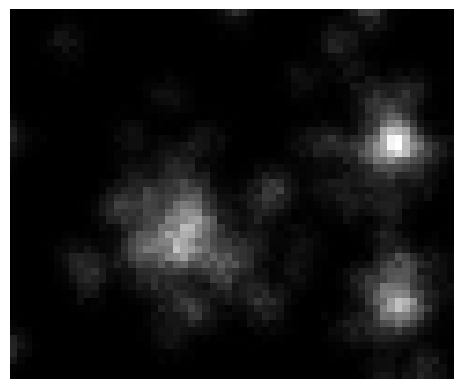

In [15]:
img_np  = images_rgb333519[12]
img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
plt.imshow(img_pil)
plt.axis('off')
plt.show()

### 2.2.2 Extract the ViT hidden states

In [16]:
hid_states333519 = []
for img in images_rgb333519:
    feat_imgs = feature_extractor(images = img, return_tensors="pt")
    outputs = model(**feat_imgs)
    last_hidden_states = outputs.last_hidden_state
    hid_states333519.append(last_hidden_states.detach().numpy().reshape(-1))

hid_states333519 = np.array(hid_states333519)

In [17]:
print(hid_states333519.shape)

(872, 151296)


## 2.3 ViT features for Grid_id = 333346

In [18]:
grid333346 = data_binned[data_binned.grid_id == 333346].drop(columns = ['grid_id'])

### 2.3.1 Transform into RGB

We now transform our heatmap data into RGB images. We further upsample the clicks using noisy bootstrap with standard dev = STDEV and number of clicks = 50000.

This code takes some time to evaluate.

In [19]:
import pandas as pd
import numpy as np
from PIL import Image

domains = grid333346['domain'].unique()
images333346 = []
labels333346 = []
for domain in domains:
    domain_df = grid333346[grid333346['domain'] == domain]
    domain_df['proba'] = domain_df.clicks_sum/domain_df.clicks_sum.sum()
    domain_df_enh = enhance_data_with_noise(domain_df, 'proba', NR_OF_SAMPLES, STDEV)

    matrix = domain_df_enh.pivot(index='click_y_bin',
                             columns='click_x_bin',
                             values='clicks_sum').fillna(0).to_numpy()
    labels333346.append(domain_df['broken'].max().astype(int))
    images333346.append(np.uint8(matrix * 255 / np.max(matrix)))
    #image = Image.fromarray(np.uint8(matrix * 255 / np.max(matrix)))

images333346 = np.array(images333346)
labels333346 = np.array(labels333346)

Stack the single greyscale channel:

In [20]:
images_rgb333346 = np.stack([np.repeat(image[:, :, np.newaxis], 3, axis=2) for image in images333346], axis=0)

Plot an example:

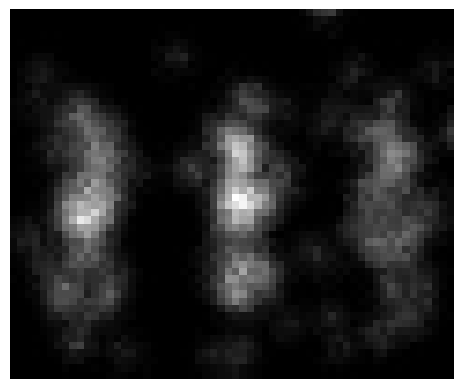

In [21]:
img_np  = images_rgb333346[32]
img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
plt.imshow(img_pil)
plt.axis('off')
plt.show()

### 2.3.2 Extract the ViT hidden states

In [22]:
hid_states333346 = []
for img in images_rgb333346:
    feat_imgs = feature_extractor(images = img, return_tensors="pt")
    outputs = model(**feat_imgs)
    last_hidden_states = outputs.last_hidden_state
    hid_states333346.append(last_hidden_states.detach().numpy().reshape(-1))

hid_states333346 = np.array(hid_states333346)

In [23]:
print(hid_states333346.shape)

(861, 151296)


# 3 Pretrained ResNet-50 model

We now perform the same for the pretrained ResNet-50 model from Huggingface

## 3.1 Load ResNet-50 from Huggingface

In [24]:
from transformers import AutoModelForImageClassification
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

RN_model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")
RN_model.classifier = torch.nn.Identity()
RN_model.eval()

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

## 3.2 ResNet features for Grid_id = 333519

In [25]:
RN_features333519 = []

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

for img_np in images_rgb333519:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = RN_model(inputs)
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_features333519.append(features_np)

RN_features333519 = np.array(RN_features333519)

In [26]:
print(RN_features333519.shape)

(872, 2048)


## 3.3 ResNet features for Grid_id = 333346

In [27]:
RN_features333346 = []

# RN_model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")
# RN_model.classifier = torch.nn.Identity()
# RN_model.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

for img_np in images_rgb333346:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = RN_model(inputs)
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_features333346.append(features_np)

RN_features333346 = np.array(RN_features333346)

In [30]:
print(RN_features333346.shape)

(861, 2048)


## 3.3 Combine ResNet features into a single vector

In [31]:
comb_feats = np.concatenate([RN_features333346, RN_features333519], axis = 0)

# 4 New Data (Data II)

We now perform the same steps as in sections 1, 2 and 3 for the new data (data II). Some of the steps (like the binning) are streamlined a bit.

## 4.1 Binning & Preprocessing

In [32]:
def binning(dataset, NR_OF_X_BINS=61, NR_OF_Y_BINS=51):

    x_bins = np.linspace(0, dataset['click_x'].max(), NR_OF_X_BINS)
    y_bins = np.linspace(0, dataset['click_y'].max(), NR_OF_Y_BINS)

    max_width  = dataset['display_width'].max()
    max_height = dataset['display_height'].max()

    width_bins_max  = NR_OF_X_BINS-2 # start at 0
    height_bins_max = NR_OF_Y_BINS-2

    dataset['click_x_bin'] = np.digitize(dataset['click_x'], x_bins) - 1
    dataset['click_y_bin'] = np.digitize(dataset['click_y'], y_bins) - 1

    binned_data = dataset.groupby(['grid_id', 'domain', 'click_x_bin', 'click_y_bin'], as_index=False)['clicks'].sum()

    dom_grids = dataset[['domain', 'grid_id']].drop_duplicates()

    aux = pd.DataFrame(list(product(range(0,width_bins_max+1),
                                    range(0,height_bins_max+1))),
                      columns=['click_x_bin', 'click_y_bin'])

    dom_grids['key'] = 1
    aux['key'] = 1

    expanded_set = pd.merge(dom_grids, aux, on='key').drop('key', axis=1)

    db = pd.merge(expanded_set, binned_data,
                      on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'],
                      how = 'left').fillna(0)
    db.rename(columns = {'clicks':'clicks_sum'}, inplace=True)
    db['clicks_sum'] = db['clicks_sum'].astype('int64')
    return db

In [36]:
data_binned_6p = binning(data_heatmap_6p, NR_OF_X_BINS = 61, NR_OF_Y_BINS = 51)

In [37]:
data_binned_6p['broken'] = 0
data_binned_6p.loc[(data_binned_6p.grid_id == 333519) &
            data_binned_6p.domain.isin(cb_333519_6p), 'broken'] = 1

data_binned_6p.loc[(data_binned_6p.grid_id == 333346) &
            data_binned_6p.domain.isin(cb_333346_6p), 'broken'] = 1

## 4.2 Preprocess with Upsampling

This takes a long time! I suspect there are faster ways of implementing this.

In [38]:
# STDEV = 1.5
NR_OF_SAMPLES = 50000

imgs_6p = []
labs_6p = []

total_clicks = data_binned_6p.groupby(['grid_id','domain'])['clicks_sum'].transform('sum')
data_binned_6p['proba'] = data_binned_6p['clicks_sum'] / total_clicks

for gid in data_binned_6p.grid_id.unique():
    domains = data_binned_6p[data_binned_6p.grid_id==gid].domain.unique()
    for domain in domains:
        domain_df = data_binned_6p[(data_binned_6p.grid_id==gid) &
                                   (data_binned_6p.domain == domain)]

        domain_df_enh = enhance_data_with_noise(domain_df, 'proba', NR_OF_SAMPLES, STDEV)

        matrix = domain_df_enh.pivot(index='click_y_bin',
                                     columns='click_x_bin',
                                     values='clicks_sum').fillna(0).to_numpy()

        labs_6p.append(domain_df['broken'].max().astype(int))
        imgs_6p.append(np.uint8(matrix * 255 / np.max(matrix)))

imgs_6p = np.array(imgs_6p)
labs_6p = np.array(labs_6p)


Stack greyscale images:

In [39]:
images_rgb_6p = np.stack([np.repeat(image[:, :, np.newaxis], 3, axis=2) for image in imgs_6p], axis=0)

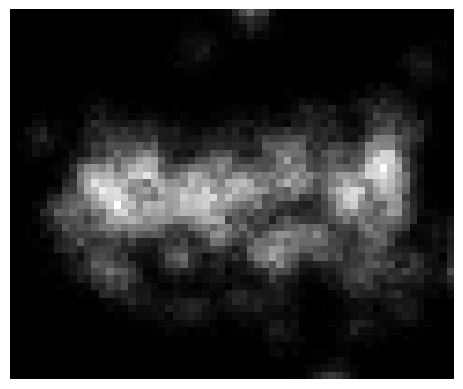

In [40]:
img_np  = images_rgb_6p[123]
img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
plt.imshow(img_pil)
plt.axis('off')
plt.show()

## 4.3 Pretrained ViT for Data II

Also quite slow (especially on CPU)

In [41]:
ViT_model = model

In [42]:
hid_states_6p = []
for img in images_rgb_6p:
    feat_imgs = feature_extractor(images = img, return_tensors="pt")
    outputs = model(**feat_imgs)
    last_hidden_states = outputs.last_hidden_state
    hid_states_6p.append(last_hidden_states.detach().numpy().reshape(-1))

In [43]:
ViT_6p = np.array(hid_states_6p)

## 4.4 Pretrained ResNet for Data II

In [44]:
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

RN_states_6p = []

for img_np in images_rgb_6p:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = RN_model(inputs)
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_states_6p.append(features_np)

In [45]:
RN_6p = np.array(RN_states_6p)

# 5 Some Bookkeeping (combining different features)

In [46]:
lab_comb  = np.concatenate([labels333519,labels333346])
RN_comb   = np.concatenate([RN_features333519,RN_features333346])
ViT_comb  = np.concatenate([hid_states333519,hid_states333346])
images_rgb_comb = np.concatenate([images_rgb333519, images_rgb333346])

# 6 Train ResNet-50 on Cluster Count

In this section, we set up the fine-tuning task of training the model to predict the number of clusters in synthetic heatmap-like data.

## 6.1 Create Synthetic Cluster Count Heatmap Class

Here we first create a simple class that generates example heatmaps with a random number of clusters (and noise) of random size.

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from itertools import product
from transformers import ResNetForImageClassification
from transformers import AutoModelForImageClassification
from torchvision.transforms import Resize


class HeatmapDataset(Dataset):
    def __init__(self,
                 num_samples,
                 max_clusters,
                 max_points_per_cluster,
                 nr_of_x_bins,
                 nr_of_y_bins,
                 max_noise,
                 max_cov,
                 transform = None):
        self.num_samples = num_samples
        self.max_clusters = max_clusters
        self.max_points_per_cluster = max_points_per_cluster
        self.nr_of_x_bins = nr_of_x_bins
        self.nr_of_y_bins = nr_of_y_bins
        self.max_noise = max_noise
        self.max_cov = max_cov
        if transform:
            self.transform = Compose([
                Resize((224, 224)),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),])
        else:
            self.transform = False

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_synthetic_heatmap()
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        if self.transform:
            image = Image.fromarray(image.astype('uint8'), 'RGB')
            image = self.transform(image)
        return image, label

    def generate_synthetic_heatmap(self):
        x = np.array([]).reshape(0,2)
        num_clusters = np.random.randint(self.max_clusters)

        for _ in range(num_clusters):
            points_per_cluster = np.random.randint(self.max_points_per_cluster)
            center = (np.random.randint(0, self.nr_of_x_bins), np.random.randint(0, self.nr_of_y_bins))

            cov_matrix = np.array([[np.random.rand() * self.max_cov, 0],
                                   [0, np.random.rand() * self.max_cov]])

            points = np.random.multivariate_normal(center, cov_matrix, points_per_cluster).round().astype(int)
            x = np.concatenate([x , points])

        # add noise
        noise_level = (np.random.randint(self.max_noise))
        noise = np.random.randint([0,0], high = [self.nr_of_x_bins+1,self.nr_of_y_bins+1], size = (noise_level,2))

        x = np.concatenate([x , noise])
        x = pd.DataFrame(data = x, columns = ['click_x_bin','click_y_bin'])

        x.loc[x['click_x_bin'] < 0, 'click_x_bin'] = 0
        x.loc[x['click_y_bin'] < 0, 'click_y_bin'] = 0
        x.loc[x['click_x_bin'] > self.nr_of_x_bins, 'click_x_bin'] = self.nr_of_x_bins
        x.loc[x['click_y_bin'] > self.nr_of_y_bins, 'click_y_bin'] = self.nr_of_y_bins

        x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

        tt = pd.DataFrame(list(product(range(0,self.nr_of_x_bins+1), range(0,self.nr_of_y_bins+1))),
                          columns=['click_x_bin', 'click_y_bin'])

        data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)

        matrix = data_obs_merged.pivot(index='click_y_bin',
                                      columns='click_x_bin',
                                      values='clicks_sum').fillna(0).to_numpy()

        image = np.uint8(matrix * 255 / np.max(matrix))

        label = num_clusters
        return image, label

Let us look at a couple of examples generated from this synthetic class:

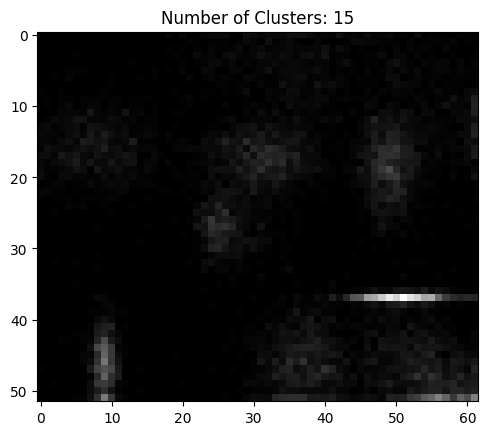

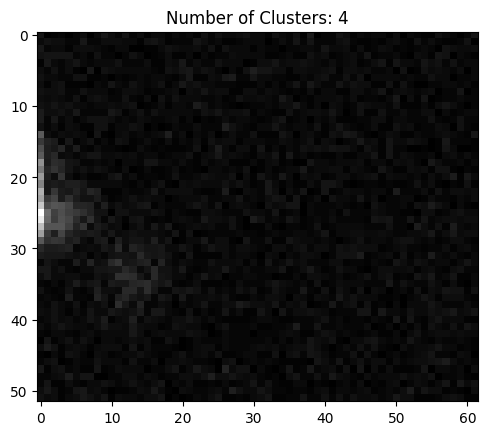

In [48]:
num_samples = 10000
max_clusters = 20
max_points_per_cluster = 1000
NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51
max_noise = 10000
max_cov = 20

dataset = HeatmapDataset(num_samples, max_clusters, max_points_per_cluster, NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, max_cov, transform = False)

image, label = dataset[0]

plt.imshow(image.squeeze())
plt.title(f'Number of Clusters: {label}')
plt.show()

image, label = dataset[1]

plt.imshow(image.squeeze())
plt.title(f'Number of Clusters: {label}')
plt.show()

## 6.2 Training the Model

In this section, we train the model on the synthetic data and task of identifying the number of classes in the heatmap.

In [49]:
num_samples = 1000
max_clusters = 20
max_points_per_cluster = 2000
NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51
max_noise = 10000
max_cov = 30

# load the model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# select the number of classes to be predicted:
num_classes = max_clusters

# attach classification head:
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training Data loader
heatmap_dataset = HeatmapDataset(num_samples, max_clusters, max_points_per_cluster,
                                 NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, max_cov, transform = True)

train_loader = DataLoader(heatmap_dataset, batch_size = 32, shuffle=True)

# Validation Data loader
num_validation_samples = 200
validation_dataset = HeatmapDataset(num_validation_samples, max_clusters, max_points_per_cluster,
                                    NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, max_cov, transform=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Loss:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            val_loss = criterion(outputs, labels)

            total_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {total_val_loss/len(validation_loader)}, Validation Accuracy: {val_accuracy}')

Epoch [1/100], Loss: 2.8932579308748245
Epoch [1/100], Validation Loss: 2.8406109469277516, Validation Accuracy: 0.105


KeyboardInterrupt: 

We can save the model:

In [ ]:
torch.save(model, 'drive/MyDrive/fine_tuned_RESENET_3.pth')

Load the model:

In [50]:
# load:
model_count = torch.load('drive/MyDrive/fine_tuned_RESENET_3.pth')

## 6.3 Create feature vectors

Given the fine-tuned model, we can create the respective feature vectors arising from applying it on the "real" data.

In [51]:
model_count = torch.load('drive/MyDrive/fine_tuned_RESENET_3.pth')
model1 = model_count
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 6.3.1 Data I

We start with grid_id = 333519

In [52]:
RN_features333519_new = []

model1.classifier = torch.nn.Identity()
model1.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

for img_np in images_rgb333519:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model1(inputs.to(device))
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_features333519_new.append(features_np)

Now, lets do start with grid_id = 333346

In [53]:
RN_features333346_new = []

for img_np in images_rgb333346:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model1(inputs.to(device))
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_features333346_new.append(features_np)

In [54]:
RN_features333519_new = np.array(RN_features333519_new)
RN_features333346_new = np.array(RN_features333346_new)
RN_comb_new   = np.concatenate([RN_features333519_new,RN_features333346_new])

### 6.3.2 Visualize PCA for new features

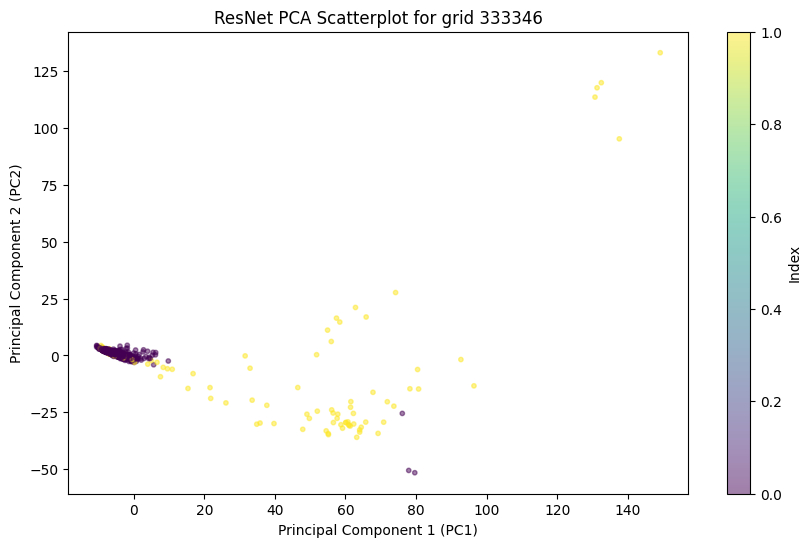

In [55]:
n_components = 10

# Instantiate the PCA model
# pca = PCA(n_components=n_components)

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

# Fit and transform the data
RNpca_result333346_new = pipeline.fit_transform(RN_features333346_new)

plt.figure(figsize=(10, 6))
plt.scatter(RNpca_result333346_new[:,0],
            RNpca_result333346_new[:,1],
            c=labels333346,
            cmap='viridis',
            alpha=0.5,
            s = 10)
plt.title('ResNet PCA Scatterplot for grid 333346')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')

### 6.3.2 Data II

In [56]:
RN_6p_cnt = []

for img_np in images_rgb_6p:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model1(inputs.to(device))
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_6p_cnt.append(features_np)

In [57]:
RN_6p_cnt = np.array(RN_6p_cnt)

# 7 Train ResNet on Cluster Location

## 7.1 Create synthetic data:

This is the loc2 version. The "older" version in the report is similar but does not contain any restrictions as to where the clusters can be --> they can be overlapping (which is somewhat unnatural).

In [58]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from itertools import product
from transformers import ResNetForImageClassification
from transformers import AutoModelForImageClassification
from torchvision.transforms import Resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image

def chamfer_distance(set1, set2):
    set1_expanded = set1.unsqueeze(2)
    set2_expanded = set2.unsqueeze(1)
    distances = torch.sum((set1_expanded - set2_expanded) ** 2, dim=-1)
    min_distances_set1 = distances.min(dim=2)[0]
    min_distances_set2 = distances.min(dim=1)[0]
    return (min_distances_set1.mean(dim=1) + min_distances_set2.mean(dim=1)).mean()


class HeatmapDataset(Dataset):
    def __init__(self, num_samples, max_clusters, max_points_per_cluster,
                 min_points_per_cluster, nr_of_x_bins, nr_of_y_bins, max_noise, min_noise, max_cov, transform=None):
        self.num_samples = num_samples
        self.max_clusters = max_clusters
        self.max_points_per_cluster = max_points_per_cluster
        self.min_points_per_cluster = min_points_per_cluster
        self.nr_of_x_bins = nr_of_x_bins
        self.nr_of_y_bins = nr_of_y_bins
        self.min_noise = min_noise
        self.max_noise = max_noise
        self.max_cov = max_cov
        if transform:
            self.transform = Compose([
                Resize((224, 224)),
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = None

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, centers = self.generate_synthetic_heatmap()
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        if self.transform:
            image = Image.fromarray(image.astype('uint8'), 'RGB')
            image = self.transform(image)

        padded_centers = np.full((self.max_clusters, 2), -1)
        padded_centers[:len(centers)] = centers

        return image, padded_centers.flatten()

    def generate_synthetic_heatmap(self):
        x = np.array([]).reshape(0, 2)
        num_clusters = np.random.randint(1, self.max_clusters + 1)

        centers = []
        excluded_regions = []
        for _ in range(num_clusters):
            points_per_cluster = np.random.randint(self.min_points_per_cluster,
                                                   self.max_points_per_cluster + 1)

            ii = 0

            # it is possible that we iterate too many times when there is only a small available region left
            # we include a cutoff here:
            while ii<100:
                ii+=1
                center = (np.random.randint(0, self.nr_of_x_bins), np.random.randint(0, self.nr_of_y_bins))

                cent_x, cent_y = center
                tot = 0
                for old_center, old_stdev in excluded_regions:

                    xc, yc = old_center
                    xd, yd = old_stdev

                    if xc-xd <= cent_x <= xc+xd and yc-yd <= cent_y <= yc+yd:
                        break
                    else:
                        tot += 1
                if tot == len(excluded_regions):
                    break

            centers.append(center)
            cov_matrix = np.array([[np.random.rand() * self.max_cov, 0],
                                   [0, np.random.rand() * self.max_cov]])

            excluded_regions.append([center,(2*cov_matrix[0,0],2*cov_matrix[1,1])])
            points = np.random.multivariate_normal(center, cov_matrix, points_per_cluster).round().astype(int)
            x = np.concatenate([x, points])

        # Add noise
        noise_level = np.random.randint(self.min_noise, self.max_noise)
        noise = np.random.randint(0, high=[self.nr_of_x_bins, self.nr_of_y_bins], size=(noise_level, 2))

        x = np.concatenate([x , noise])

        x = pd.DataFrame(data = x, columns = ['click_x_bin','click_y_bin'])

        x.loc[x['click_x_bin'] < 0, 'click_x_bin'] = 0
        x.loc[x['click_y_bin'] < 0, 'click_y_bin'] = 0
        x.loc[x['click_x_bin'] > self.nr_of_x_bins, 'click_x_bin'] = self.nr_of_x_bins
        x.loc[x['click_y_bin'] > self.nr_of_y_bins, 'click_y_bin'] = self.nr_of_y_bins

        x = x.groupby(['click_x_bin','click_y_bin']).size().reset_index(name = 'clicks_sum')

        tt = pd.DataFrame(list(product(range(0,self.nr_of_x_bins+1), range(0,self.nr_of_y_bins+1))),
                          columns=['click_x_bin', 'click_y_bin'])

        data_obs_merged = tt.merge(x, on = ['click_x_bin','click_y_bin'], how = 'left').fillna(0)

        matrix = data_obs_merged.pivot(index='click_y_bin',
                                      columns='click_x_bin',
                                      values='clicks_sum').fillna(0).to_numpy()

        image = np.uint8(matrix * 255 / np.max(matrix))

        return image, centers

# Constants
num_samples = 1000
max_clusters = 10
max_points_per_cluster = 1000
min_points_per_cluster = 100
NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51
max_noise = 20000
min_noise = 1000
max_cov = 10

Let's plot a couple of examples:

One could potentially play a bit more with the parameters in the heatmap generation to get smth closer to the actual data?

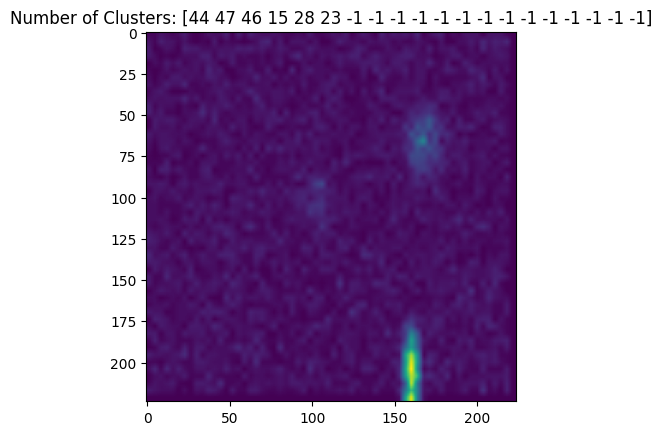

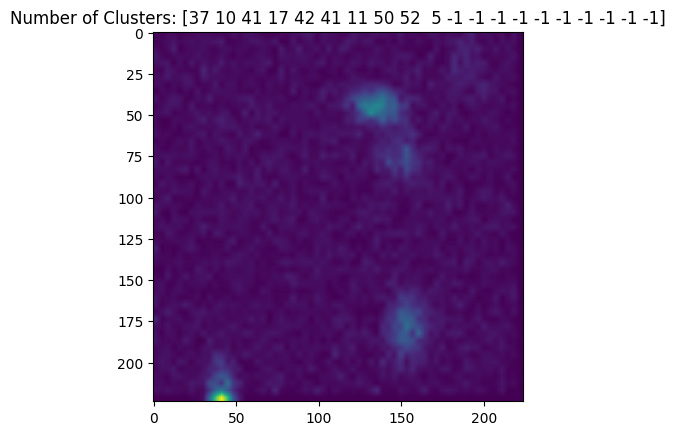

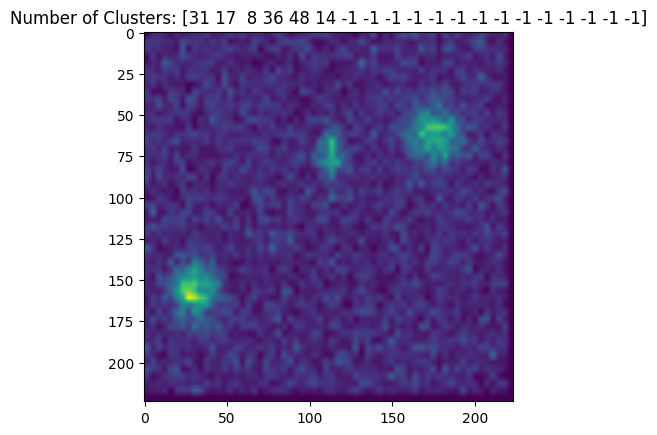

In [59]:
dataset = HeatmapDataset(num_samples, max_clusters, max_points_per_cluster, min_points_per_cluster,
                                 NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, min_noise, max_cov, transform=True)

image, label = dataset[0]

plt.imshow(image[1,:,:].squeeze())
plt.title(f'Number of Clusters: {label}')
plt.show()

image, label = dataset[1]

plt.imshow(image[1,:,:].squeeze())
plt.title(f'Number of Clusters: {label}')
plt.show()

image, label = dataset[2]

plt.imshow(image[1,:,:].squeeze())
plt.title(f'Number of Clusters: {label}')
plt.show()

## 7.2 Training the Model

In [60]:
# Load the model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# Modify the model for regression output
num_coordinates = 2 * max_clusters  # x and y for each cluster
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_coordinates)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create the dataset
heatmap_dataset = HeatmapDataset(num_samples, max_clusters, max_points_per_cluster, min_points_per_cluster,
                                 NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, min_noise, max_cov, transform=True)

# DataLoader
train_loader = DataLoader(heatmap_dataset, batch_size=32, shuffle=True)

num_validation_samples = 100
validation_dataset = HeatmapDataset(num_samples, max_clusters, max_points_per_cluster, min_points_per_cluster,
                                 NR_OF_X_BINS, NR_OF_Y_BINS, max_noise, min_noise, max_cov, transform=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, centers in train_loader:
        images = images.to(device)
        centers = centers.to(device)  # Centers are already flattened when loaded

        outputs = model(images).logits  # Assuming the output has the shape [batch_size, num_centers*2]
        outputs = outputs.view(-1, max_clusters, 2)  # Reshape to [batch_size, num_centers, 2] for x, y coordinates

        # Prepare true centers for comparison
        true_centers = centers.view(-1, max_clusters, 2)  # Reshape to [batch_size, num_clusters, 2]

        # Calculate Chamfer-like distance as loss
        loss = chamfer_distance(outputs, true_centers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for images, centers in validation_loader:
            images, centers = images.to(device), centers.to(device)
            outputs = model(images).logits
            outputs = outputs.view(-1, max_clusters, 2)

            true_centers = centers.view(-1, max_clusters, 2)

            loss = chamfer_distance(outputs, true_centers)
            total_val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {total_val_loss/len(validation_loader)}')


Epoch [1/50], Loss: 1136.6562271118164
Epoch [1/50], Validation Loss: 1152.936939239502
Epoch [2/50], Loss: 1077.6555461883545
Epoch [2/50], Validation Loss: 1103.0374336242676


KeyboardInterrupt: 

Save the model:

In [ ]:
torch.save(model, 'drive/MyDrive/fine_tuned_RESENET_loc_of_centers_newer_method.pth')
# model = torch.load('drive/MyDrive/fine_tuned_RESENET_loc_of_centers.pth')

Load the model:

In [66]:
model_loc = torch.load('drive/MyDrive/fine_tuned_RESENET_loc_of_centers.pth')

model2 = model_loc

## 7.3 Create feature vectors:

### 7.3.1 Data I

In [78]:
#model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")
model2.classifier = torch.nn.Identity()
model2.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

RN_loc_new = []

for img_np in images_rgb_comb:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model2_new(inputs.to(device))
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_loc_new.append(features_np)

RN_loc_new = np.array(RN_loc_new)

### 7.3.2 Data II

In [79]:
model2_new = model
model2_new.classifier = torch.nn.Identity()
model2_new.eval()


transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),])

RN_6p_loc_new = []

for img_np in images_rgb_6p:
    img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
    img_tensor = transform(img_pil)
    inputs = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model2_new(inputs.to(device))
        features = output.last_hidden_state if hasattr(output, 'last_hidden_state') else output[0]

    features_np = features.cpu().detach().numpy().reshape(-1)
    RN_6p_loc_new.append(features_np)

RN_6p_loc_new = np.array(RN_6p_loc_new)

# 8 Pickle Save Feature Vectors

We save the feature vectors in a pickle file and evaluate/create the predictive model in another file.

In [80]:
RN_comb       = np.concatenate([RN_features333519,RN_features333346])
RN_comb_loc   = np.concatenate([RN_features333519_loc,RN_features333346_loc])
RN_comb_cnt   = np.concatenate([RN_features333519_new,RN_features333346_new])

In [81]:
doms_old = {}

domains = grid333519['domain'].unique()
doms_old[333519] = np.array([domain for domain in domains])
domains = grid333346['domain'].unique()
doms_old[333346] = np.array([domain for domain in domains])

In [82]:
doms_new = {}
for gid in data_binned_6p.grid_id.unique():
    domains = data_binned_6p[data_binned_6p.grid_id==gid].domain.unique()
    doms_new[gid] = np.array([domain for domain in domains])

In [83]:
import pickle

save_feats = {}
save_feats['RN_pre'] = RN_comb
save_feats['RN_comb_loc'] = RN_comb_loc
save_feats['RN_comb_loc_new'] = RN_loc_new
save_feats['RN_comb_cnt'] = RN_comb_cnt
save_feats['ViT_comb'] = ViT_comb
save_feats['lab_comb'] = lab_comb
save_feats['images_rgb_comb'] = images_rgb_comb
save_feats['doms_old'] = doms_old


save_feats['RN_6p'] = RN_6p
save_feats['RN_6p_loc'] = RN_6p_loc
save_feats['RN_6p_comb_loc_new'] = RN_6p_loc_new
save_feats['RN_6p_cnt'] = RN_6p_cnt
save_feats['ViT_6p'] = ViT_6p
save_feats['labs_6p'] = labs_6p
save_feats['images_rgb_6p'] = images_rgb_6p
save_feats['doms_new'] = doms_new

save_feats['RN_comb_loc_new'] = RN_loc_new
save_feats['RN_6p_comb_loc_new'] = RN_6p_loc_new
with open('drive/MyDrive/Capstone/save_feats_new1.pkl', 'wb') as f:
    pickle.dump(save_feats, f)

NameError: name 'RN_6p_loc' is not defined